In [11]:
import warnings
warnings.filterwarnings('ignore')
import kagglehub
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")
print("Path to dataset files:", path)

Path to dataset files: /home/elixer/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4


In [14]:
DATASET_PATH = "/home/elixer/.cache/kagglehub/datasets/divyansh22/dummy-astronomy-data/versions/4/Cutout Files"
star_path = os.path.join(DATASET_PATH, "star")
galaxy_path = os.path.join(DATASET_PATH, "galaxy")
print("Number of star images:", len(os.listdir(star_path)))
print("Number of galaxy images:", len(os.listdir(galaxy_path)))

Number of star images: 3044
Number of galaxy images: 942


In [15]:
def load_images_from_folder(folder, label, augment=False):
    images = []
    labels = []
    datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.2, 
        height_shift_range=0.2, 
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    for filename in os.listdir(folder):
        img = keras.preprocessing.image.load_img(os.path.join(folder, filename), target_size=(64, 64))
        img = keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize
        images.append(img)
        labels.append(label)
        
        # Augment only if it's a galaxy image (minority class)
        if augment:
            img = np.expand_dims(img, axis=0)
            for _ in range(2):  # Generate two augmented versions per image
                aug_img = datagen.flow(img, batch_size=1)[0]
                images.append(aug_img[0])
                labels.append(label)
    
    return images, labels


In [16]:
star_images, star_labels = load_images_from_folder(os.path.join(DATASET_PATH, 'star'), 0)
galaxy_images, galaxy_labels = load_images_from_folder(os.path.join(DATASET_PATH, 'galaxy'), 1, augment=True)

In [17]:
X = np.array(star_images + galaxy_images)
y = np.array(star_labels + galaxy_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)


In [47]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='huber', metrics=['accuracy'])
    return model

In [49]:
model = build_model()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7728 - loss: 0.0796 - val_accuracy: 0.8194 - val_loss: 0.0658
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8341 - loss: 0.0582 - val_accuracy: 0.8893 - val_loss: 0.0410
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8950 - loss: 0.0391 - val_accuracy: 0.9199 - val_loss: 0.0298
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9076 - loss: 0.0346 - val_accuracy: 0.9412 - val_loss: 0.0246
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9204 - loss: 0.0289 - val_accuracy: 0.9148 - val_loss: 0.0323
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9276 - loss: 0.0276 - val_accuracy: 0.9242 - val_loss: 0.0287
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9346 - loss: 0.0248 - val_accuracy: 0.9421 - val_loss: 0.0222
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9463 - loss: 0.0209 - val_accu

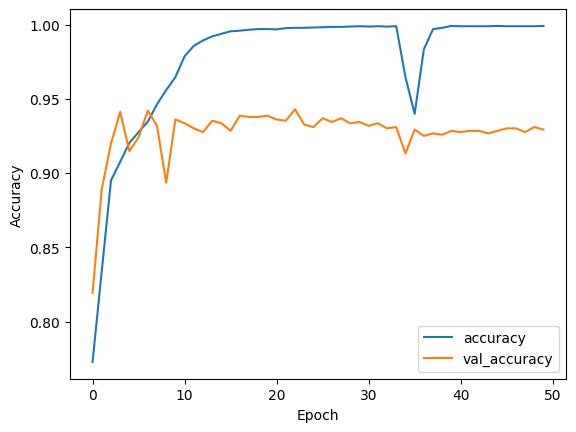

In [50]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [51]:
model.save("my_model_star_galaxy_classifier.h5")